<a href="https://colab.research.google.com/github/Edudeiko/DS-Unit-2-Applied-Modeling/blob/master/E_D_heart__disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define ML problems
**You will use your portfolio project dataset for all assignments this sprint.
Assignment**

Complete these tasks for your project, and document your decisions.

[ ] Choose your target. Which column in your tabular dataset will you predict?

[ ] Is your problem regression or classification?

[ ] How is your target distributed?

**Classification: How many classes? Are the classes imbalanced?
Regression: Is the target right-skewed? If so, you may want to log transform the target.**

[ ] Choose which observations you will use to train, validate, and test your model.

Are some observations outliers? Will you exclude them?
Will you do a random split or a time-based split?

[ ] Choose your evaluation metric(s).

**Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?**

[ ] Begin to clean and explore your data.

[ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

###Loading Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*

###Loading Data Set

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install eli5
    !pip install pdpbox
    !pip install shap

In [0]:
heart_csv = 'heart.csv'

In [0]:
hd = pd.read_csv(heart_csv, header=0)

In [0]:
hd.reset_index(level=0, inplace=True)

In [8]:
print(hd.shape)
hd.head(3)

(303, 15)


index  age  sex  cp  trestbps  chol  ...  exang  oldpeak  slope  ca  thal  target
0      0   63    1   3       145   233  ...      0      2.3      0   0     1       1
1      1   37    1   2       130   250  ...      0      3.5      0   0     2       1
2      2   41    0   1       130   204  ...      0      1.4      2   0     2       1

[3 rows x 15 columns]

###Rename columns for easy read

In [0]:
# Rename columns for ease read
hd.rename(columns={'cp':'chest_pain', 'trestbps':'rest_blood_pres_on_admission', 'fbs':'fasting_blood_sugar_120',
                   'restecg':'resting_electrocardiographic_results', 'thalach':'max_heart_rate_achieved',
                   'exang':'exercise_induced_angina', 'oldpeak':'depression_induced_by_exercise_relative_to_rest',
                   'ca':'number_of_major_vessels', 'chol':'cholestoral', 'slope':'slope_of_the_peak_exercise'}, inplace=True)

In [10]:
hd.sample(2)

index  age  sex  ...  number_of_major_vessels  thal  target
219    219   48    1  ...                        2     3       0
207    207   60    0  ...                        2     3       0

[2 rows x 15 columns]

###Explore Target

In [0]:
# Choose your target. Which column in your tabular dataset will you predict?
# Target is column 'target'
# I will predict if the test subject has the disease or not.

In [11]:
# 54% has the disease
# 46% doesn't have the disease
hd['target'].value_counts(normalize=True)

1    0.544554
0    0.455446
Name: target, dtype: float64

In [0]:
# How is your target distributed?

In [0]:
target = hd['target']

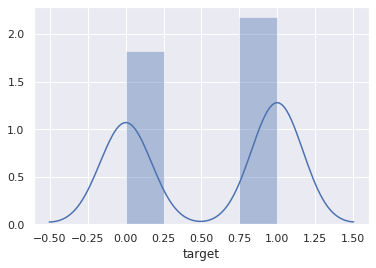

In [13]:
import seaborn as sns
sns.set()
sns.distplot(target);

In [0]:
# 1. Is your problem regression or classification?
# 2. Classification: How many classes? Are the classes imbalanced? 

# There are 2 classes, this is a binary classification problem.
# I wouldn't say the classes are imbalanced. The difference is close to 50%/50%.

In [0]:
target.describe()

count    303.000000
mean       0.544554
std        0.498835
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

###Pandas profiling

In [0]:
import pandas_profiling
hd.profile_report()

In [0]:
# Choose which observations you will use to train, validate, and test your model.
# Will you do a random split or a time-based split?
# Are some observations outliers? Will you exclude them? Will you do a random split or a time-based split?

# I've decided to split the data set randomly

# Looking at the pandas profiling I can spot 4 categorical values, which I will later transform to numeric.

# This data set dosen't have a high cardinallity values

###Get dummies for Categorical features

In [0]:
# I decided to encode the 4 categorical features I spoted browsing pandas_profiling
import category_encoders as ce

hd = pd.get_dummies(hd, columns=['chest_pain', 'resting_electrocardiographic_results',
                            'slope_of_the_peak_exercise', 'thal'])

In [14]:
hd.head()

index  age  sex  ...  thal_1  thal_2  thal_3
0      0   63    1  ...       1       0       0
1      1   37    1  ...       0       1       0
2      2   41    0  ...       0       1       0
3      3   56    1  ...       0       1       0
4      4   57    0  ...       0       1       0

[5 rows x 25 columns]

###Train, Test & Train to Train, Val split

In [15]:
# 1st train and test

train, test = train_test_split(hd, train_size=0.80, test_size=0.20, 
                              stratify=hd['target'], random_state=42)
train.shape, test.shape

((242, 25), (61, 25))

In [16]:
# 2nd train split in to train and validation data sets

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['target'], random_state=42)
train.shape, val.shape

((193, 25), (49, 25))

In [17]:
print('Train set shape:', train.shape)
print('Val set shape:', val.shape)
print('Test set shape:', test.shape)

Train set shape: (193, 25)
Val set shape: (49, 25)
Test set shape: (61, 25)


###Get the Baseline score

In [0]:
target = 'target'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [0]:
# Choose your evaluation metric(s).

# I will use accuracy_score for now, may change it later on
from sklearn.metrics import accuracy_score

In [20]:
# My Baseline accuracy 55%
majority = y_val.mode()[0]
y_pred = [majority] * len(y_val)
y_val = val[target]
y_pred = [majority] * len(y_val)
accuracy_score(y_val, y_pred)
print('Score:', accuracy_score(y_val, y_pred))

Score: 0.5510204081632653


In [0]:
# I have my base score now. Let's do some more exploring and possibly wrangling

In [0]:
# 1. Begin to clean and explore your data.
# 2. Begin to choose which features, if any, to exclude.

###Basic exploration

In [22]:
train.groupby('target')['age'].value_counts(normalize=True).sort_values(ascending=False).head(8)

target  age
0       58     0.090909
        57     0.068182
1       51     0.066667
        41     0.057143
0       59     0.056818
        61     0.056818
1       44     0.047619
        64     0.047619
Name: age, dtype: float64

In [23]:
train['thal_2'].value_counts(normalize=True).sort_values()

0    0.450777
1    0.549223
Name: thal_2, dtype: float64

In [24]:
train.describe(include='all').T

count  ...    max
index                                            193.0  ...  300.0
age                                              193.0  ...   77.0
sex                                              193.0  ...    1.0
rest_blood_pres_on_admission                     193.0  ...  200.0
cholestoral                                      193.0  ...  409.0
fasting_blood_sugar_120                          193.0  ...    1.0
max_heart_rate_achieved                          193.0  ...  202.0
exercise_induced_angina                          193.0  ...    1.0
depression_induced_by_exercise_relative_to_rest  193.0  ...    6.2
number_of_major_vessels                          193.0  ...    4.0
target                                           193.0  ...    1.0
chest_pain_0                                     193.0  ...    1.0
chest_pain_1                                     193.0  ...    1.0
chest_pain_2                                     193.0  ...    1.0
chest_pain_3                                     193.0  ...    1.0
resting_electrocardiographic_results_0           193.0  ...    1.0
resting_electrocardiographic_results_1           193.0  ...    1.0
resting_electrocardiographic_results_2           193.0  ...    1.0
slope_of_the_peak_exercise_0                     193.0  ...    1.0
slope_of_the_peak_exercise_1                     193.0  ...    1.0
slope_of_the_peak_exercise_2                     193.0  ...    1.0
thal_0                                           193.0  ...    0.0
thal_1                                           193.0  ...    1.0
thal_2                                           193.0  ...    1.0
thal_3                                           193.0  ...    1.0

[25 rows x 8 columns]

In [25]:
# Check for unique values
train.nunique().sort_values(ascending=False)

index                                              193
cholestoral                                        124
max_heart_rate_achieved                             77
rest_blood_pres_on_admission                        44
age                                                 40
depression_induced_by_exercise_relative_to_rest     38
number_of_major_vessels                              5
chest_pain_0                                         2
sex                                                  2
fasting_blood_sugar_120                              2
exercise_induced_angina                              2
target                                               2
thal_3                                               2
thal_2                                               2
chest_pain_2                                         2
chest_pain_3                                         2
resting_electrocardiographic_results_0               2
resting_electrocardiographic_results_1               2
resting_el

In [26]:
train['cholestoral'].value_counts().sort_values(ascending=False).head(5)

254    4
197    4
234    4
243    4
204    3
Name: cholestoral, dtype: int64

In [0]:
# I can see that thal_0 has got only 1 value, I will remove it later on.
# I might remove 'cholestoral' with high cardinality values as well
# I will plot them first

In [28]:
train.dtypes

index                                                int64
age                                                  int64
sex                                                  int64
rest_blood_pres_on_admission                         int64
cholestoral                                          int64
fasting_blood_sugar_120                              int64
max_heart_rate_achieved                              int64
exercise_induced_angina                              int64
depression_induced_by_exercise_relative_to_rest    float64
number_of_major_vessels                              int64
target                                               int64
chest_pain_0                                         uint8
chest_pain_1                                         uint8
chest_pain_2                                         uint8
chest_pain_3                                         uint8
resting_electrocardiographic_results_0               uint8
resting_electrocardiographic_results_1               uin

In [29]:
train.isnull().sum()

index                                              0
age                                                0
sex                                                0
rest_blood_pres_on_admission                       0
cholestoral                                        0
fasting_blood_sugar_120                            0
max_heart_rate_achieved                            0
exercise_induced_angina                            0
depression_induced_by_exercise_relative_to_rest    0
number_of_major_vessels                            0
target                                             0
chest_pain_0                                       0
chest_pain_1                                       0
chest_pain_2                                       0
chest_pain_3                                       0
resting_electrocardiographic_results_0             0
resting_electrocardiographic_results_1             0
resting_electrocardiographic_results_2             0
slope_of_the_peak_exercise_0                  

In [0]:
# hd['chest_pain'] = hd['chest_pain'].astype('category')
# hd['resting_electrocardiographic_results'] = hd['resting_electrocardiographic_results'].astype('category')
# hd['slope_of_the_peak_exercise'] = hd['slope_of_the_peak_exercise'].astype('category')
# hd['thal'] = hd['thal'].astype('category')

In [30]:
train.head(2)

index  age  sex  ...  thal_1  thal_2  thal_3
111    111   57    1  ...       0       0       1
196    196   46    1  ...       0       1       0

[2 rows x 25 columns]

###Visualization

In [0]:
# from the plots below, I can see possible feature vs target dependency
# Also I can have a look at the feature importances 

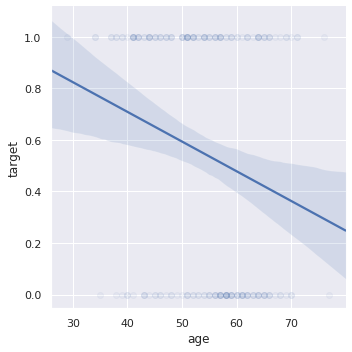

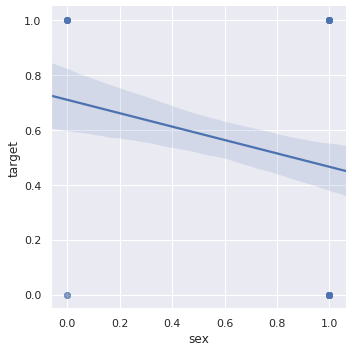

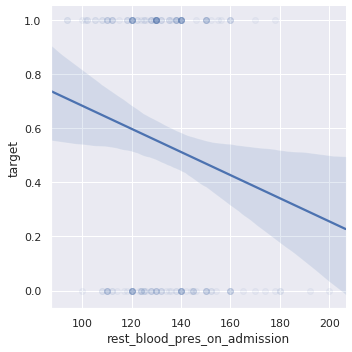

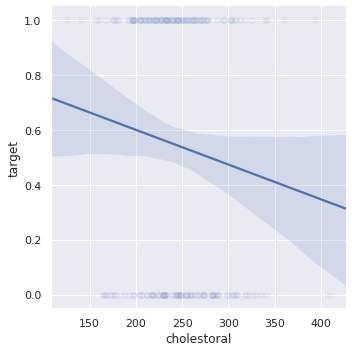

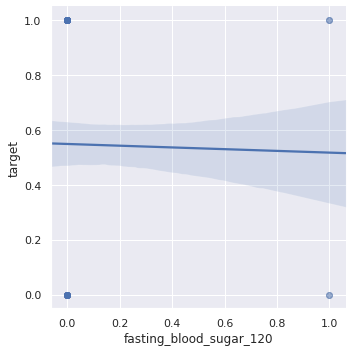

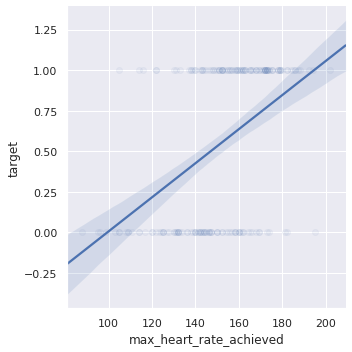

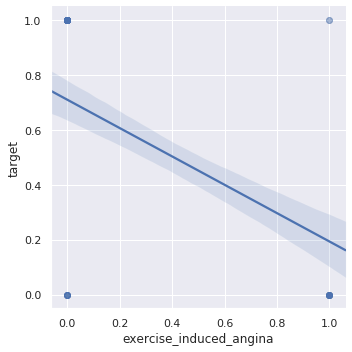

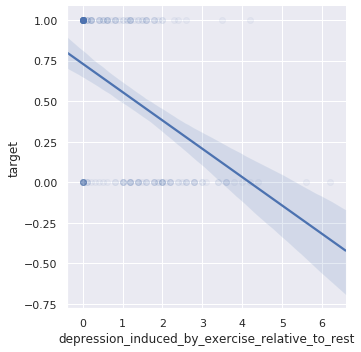

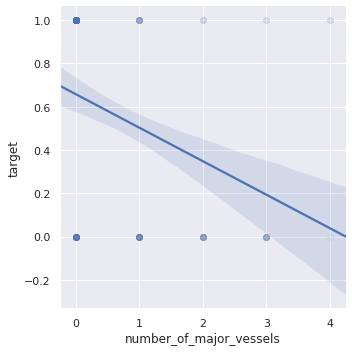

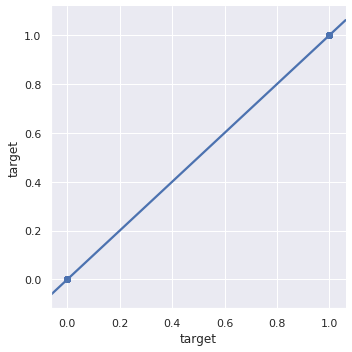

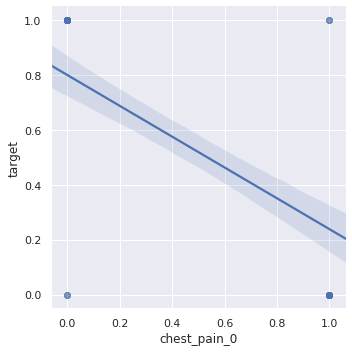

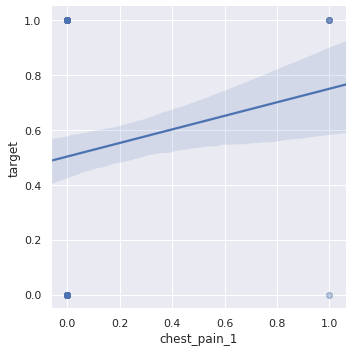

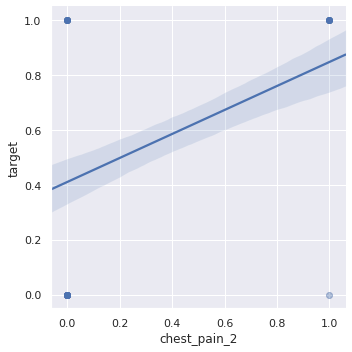

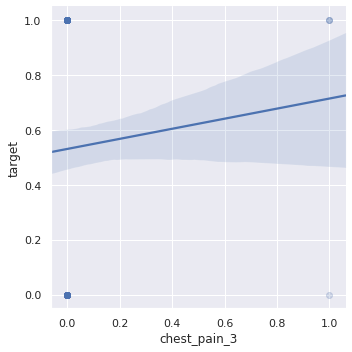

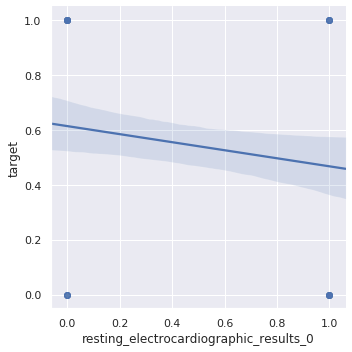

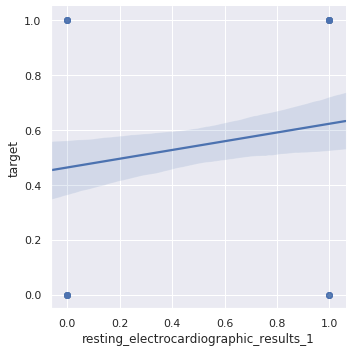

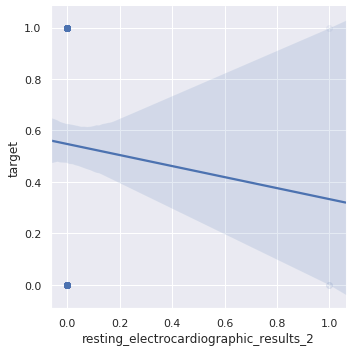

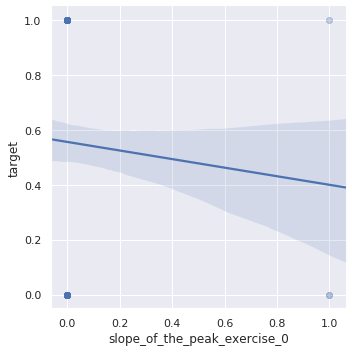

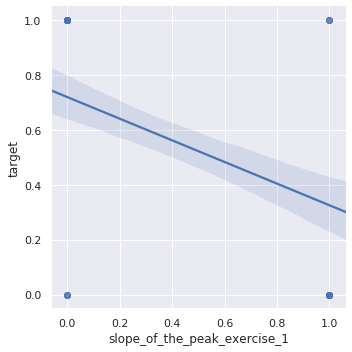

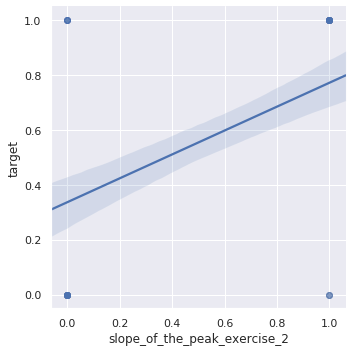

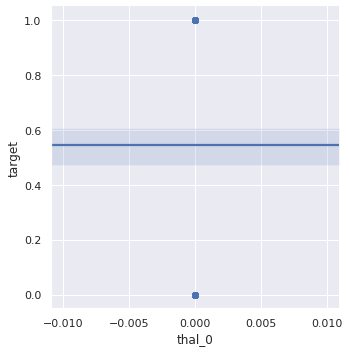

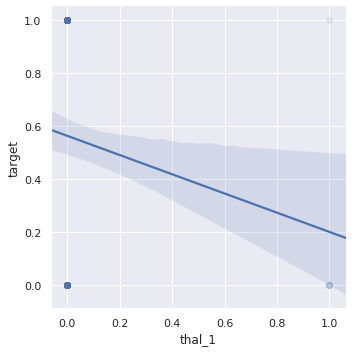

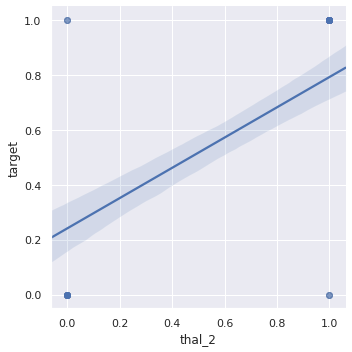

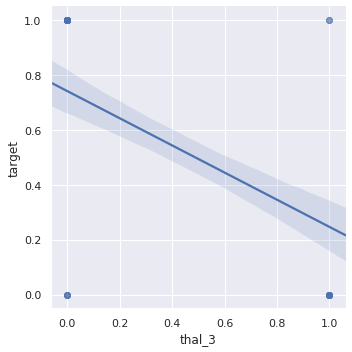

In [0]:
numeric = train.select_dtypes('number')
for feature in numeric:
  sns.lmplot(x=feature, y=target, data=train, scatter_kws={'alpha': 0.05})
  plt.show()

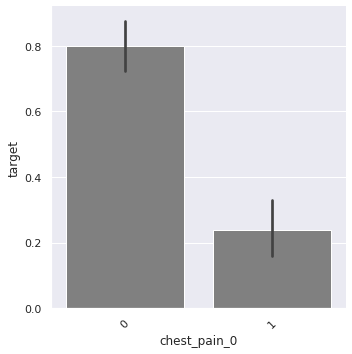

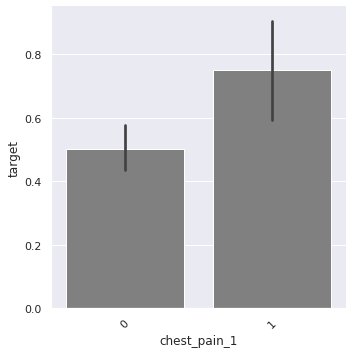

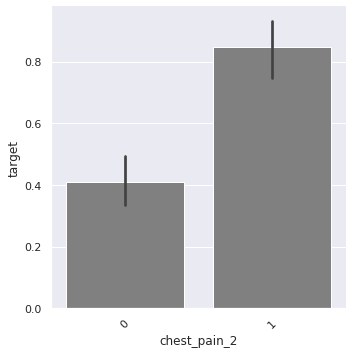

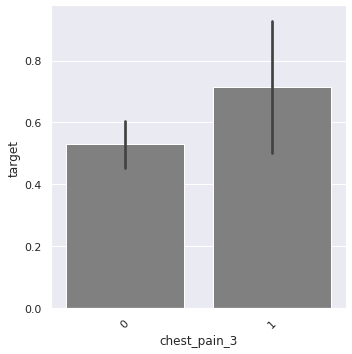

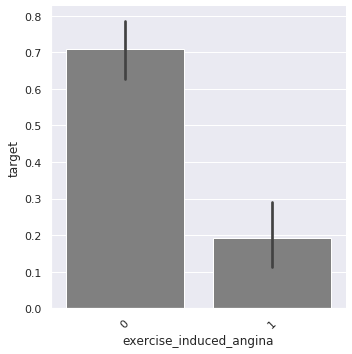

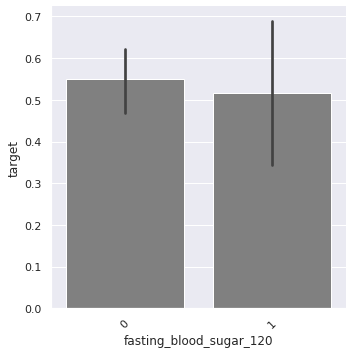

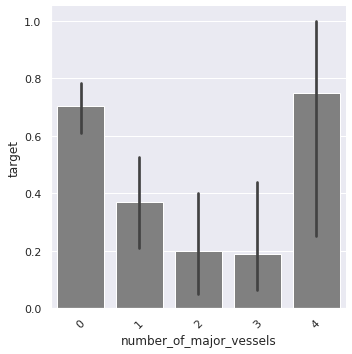

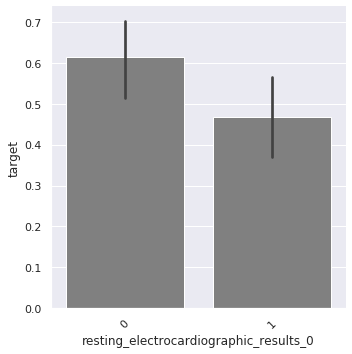

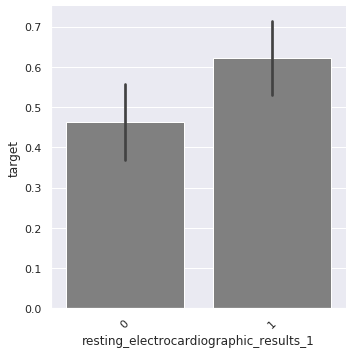

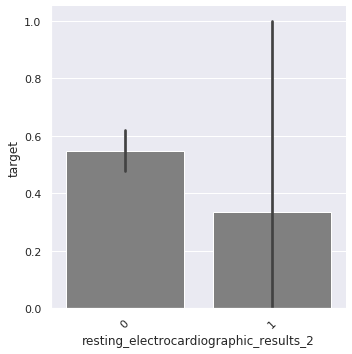

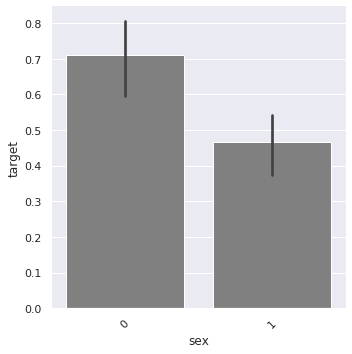

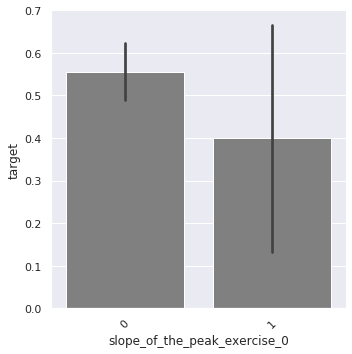

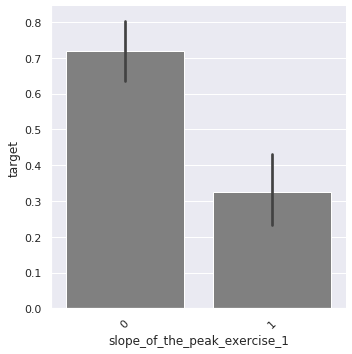

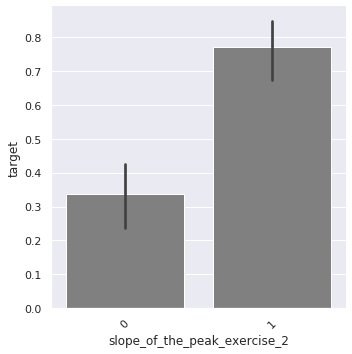

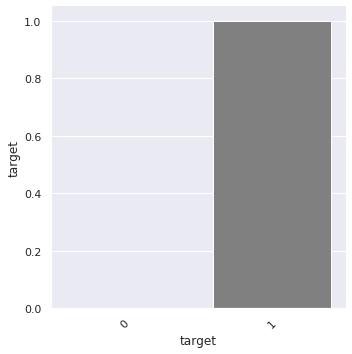

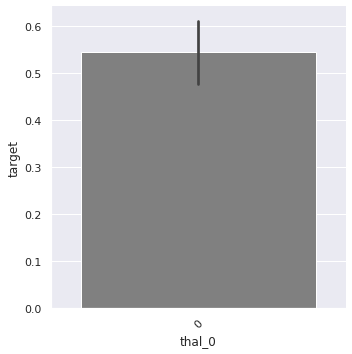

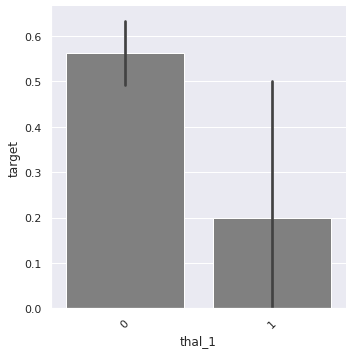

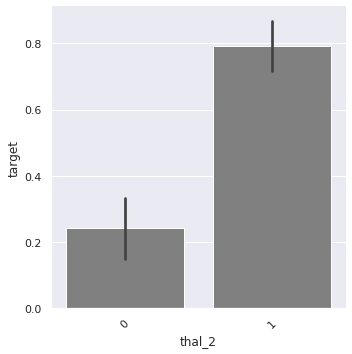

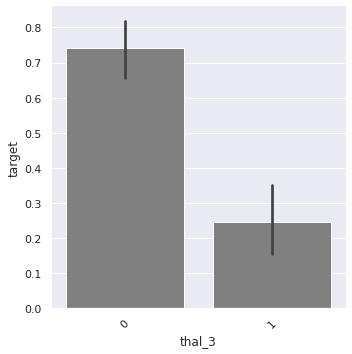

In [0]:
import seaborn as sns
for col in sorted (train.columns):
  if train [col].nunique() <= 20:
    sns.catplot(x=col, y='target', data=train, kind='bar', color='grey')
    plt.xticks(rotation=45)
    plt.show()

In [0]:
# from this plots I can see the possibility for further data wrangling

###Data wrangling

In [0]:
# Save the ids(index) for later use. I can look up actual results and compare it with predicted results
train_id = X_train['index']
val_id = X_val['index']
test_id = X_test['index']

In [0]:
def wrangle(X):
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # Drop single value columns
    single_value_feature = ['thal_0']
    X = X.drop(columns=single_value_feature)
    
    # Drop unusable variance
    unusable_variance = ['index']
    X = X.drop(columns=unusable_variance)

    # I decided to keep the rest of the data for now

    return X

X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)

###Logistic Regression model

In [0]:
# First I will run Logistic Regression with all the features

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [0]:
log_reg = LogisticRegression(solver='newton-cg')

In [25]:
log_reg.fit(X_train, y_train)
print('Test Accuracy with LogisticRegression', log_reg.score(X_val, y_val))

Test Accuracy with LogisticRegression 0.8367346938775511


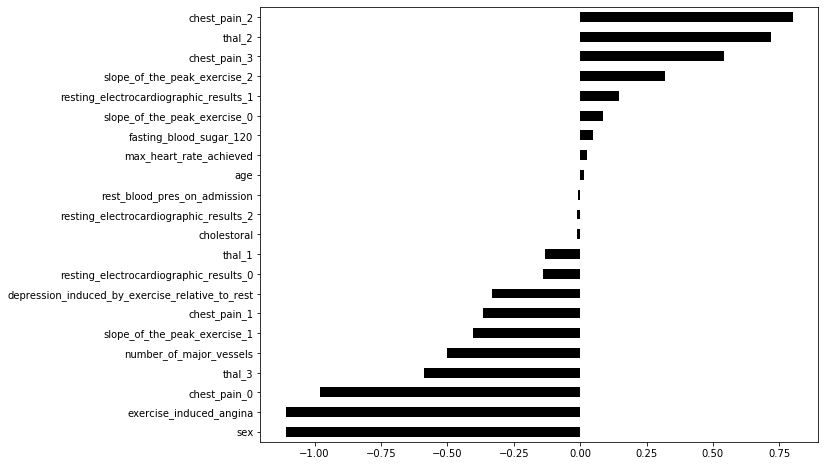

In [26]:
# Now I can see all the feature importancies for the LogisticRegression model
coefficients = pd.Series(log_reg.coef_[0], X_val.columns)
plt.figure(figsize=(10,8))
coefficients.sort_values().plot.barh(color='black');

In [27]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    log_reg,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='newton-cg',
                                                   tol=0.0001, verbose=0,
                                                   warm_start=False),
                      n_iter=5, random_state=42, refit=True,
                      scoring='accuracy')

In [28]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist())

###Desicion Tree Classifier model

In [0]:
# Now I will fit DecisionTreeClassifier

In [0]:
dtc = DecisionTreeClassifier(max_depth=3)

In [40]:
dtc.fit(X_train, y_train)
print('Validation Accuracy with DecisionTreeClassifier:', dtc.score(X_val, y_val))

Validation Accuracy with DecisionTreeClassifier: 0.8367346938775511


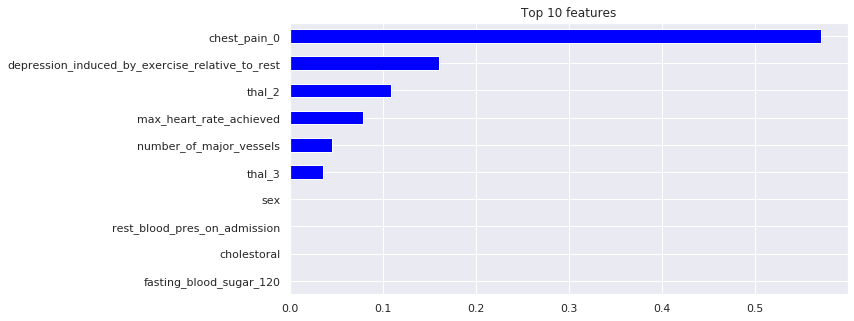

In [41]:
# Get feature importances for DecisionTreeClassifier

importances = pd.Series(dtc.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

In [42]:
permuter = PermutationImportance(
    dtc,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=DecisionTreeClassifier(class_weight=None,
                                                       criterion='gini',
                                                       max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       spl

In [43]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist())

###Random Forest Classifier

In [0]:
# Now I will fit RandomForestClassifier

In [0]:
rf = RandomForestClassifier(n_estimators=400, max_features='auto', max_depth=70,
                           min_samples_leaf=2, min_samples_split=5,
                           random_state=42, n_jobs=-1)

In [30]:
rf.fit(X_train, y_train)
print('Validation Accuracy with RandomForestClassifier:', rf.score(X_val, y_val))

Validation Accuracy with RandomForestClassifier: 0.8571428571428571


In [0]:
# I did the RandomizedSearchCV as well, but it did not give me a better score

In [0]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

In [32]:
param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


In [33]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 15, 'max_features': 0.09997491581800289, 'n_estimators': 137}
Cross-validation MAE 0.22279792746113988


In [34]:
model.fit(X_train, y_train)
print('Validation Accuracy with RandomForestClassifier:', model.score(X_val, y_val))

Validation Accuracy with RandomForestClassifier: 0.8367346938775511


In [0]:
# RandomizedSearch did not give me a better result

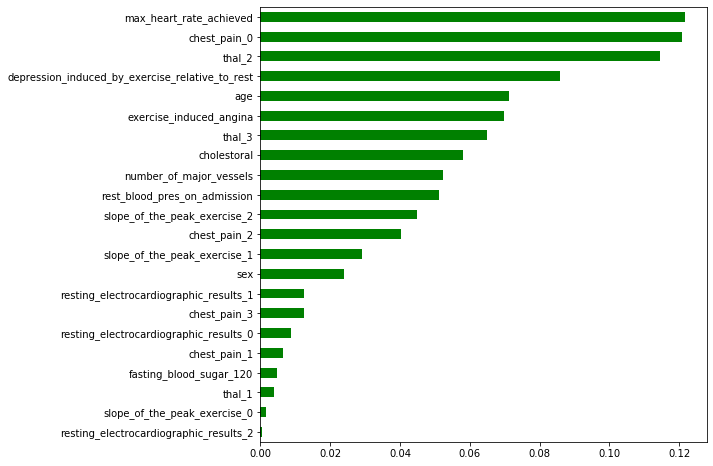

In [35]:
# Get feature importances for RandomForestClassifier

plt.figure(figsize=(8,8))
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='green');

In [36]:
permuter = PermutationImportance(
    rf,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=70,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=400,
                                                       

In [37]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist())

###XGBoost Classifier

In [38]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit on train, score on val
xgb.fit(X_train, y_train)
print('Validation Accuracy:', xgb.score(X_val, y_val))

Validation Accuracy: 0.8163265306122449


In [55]:
from sklearn.metrics import roc_auc_score

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.910768	validation_1-auc:0.861111
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92408	validation_1-auc:0.912458
[2]	validation_0-auc:0.931602	validation_1-auc:0.914983
[3]	validation_0-auc:0.939881	validation_1-auc:0.905724
[4]	validation_0-auc:0.937392	validation_1-auc:0.907407
[5]	validation_0-auc:0.943236	validation_1-auc:0.902357
[6]	validation_0-auc:0.951299	validation_1-auc:0.905724
[7]	validation_0-auc:0.957684	validation_1-auc:0.904882
[8]	validation_0-auc:0.961526	validation_1-auc:0.906566
[9]	validation_0-auc:0.9625	validation_1-auc:0.904882
[10]	validation_0-auc:0.963799	validation_1-auc:0.896465
[11]	validation_0-auc:0.964935	validation_1-auc:0.907407
[12]	validation_0-auc:0.966991	validation_1-auc:0.910774
Stopping. Best iteration:
[2]	validation_0-auc:0.931602	validation_1-auc:0.914983



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [56]:
permuter = PermutationImportance(
    xgb,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                   

In [57]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist())

###Apply Random Forest Classifier to Test data set

In [0]:
# I decided to stick with RandomForestClassifier rf for my TEST set.

In [39]:
rf.fit(X_train, y_train)
# y_pred_test = rf.predict(X_test)
print('Accuracy for Test data set:', rf.score(X_test ,y_test))

Accuracy for Test data set: 0.8032786885245902


###Roc Curve

In [0]:
from sklearn.metrics import roc_curve
y_pred_proba = rf.predict_proba(X_val)[:, -1] # Probability for last class
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [41]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

False Positive Rate  True Positive Rate  Threshold
0              0.000000            0.000000   1.984264
1              0.000000            0.037037   0.984264
2              0.000000            0.555556   0.732147
3              0.045455            0.555556   0.711855
4              0.045455            0.592593   0.695010
5              0.090909            0.592593   0.626844
6              0.090909            0.851852   0.492970
7              0.272727            0.851852   0.393045
8              0.272727            0.888889   0.390756
9              0.318182            0.888889   0.380298
10             0.318182            0.962963   0.376323
11             0.409091            0.962963   0.219373
12             0.409091            1.000000   0.202778
13             1.000000            1.000000   0.011829

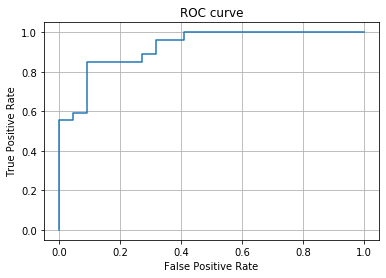

In [42]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.grid(True)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [43]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.9259259259259258

###Partial Dependance Plots (PDP Plot)

In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [0]:
plt.rcParams['figure.dpi'] = 72

In [0]:
! pip install pdpbox

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [0]:
feature='age'

isolated = pdp_isolate(
    model = rf,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


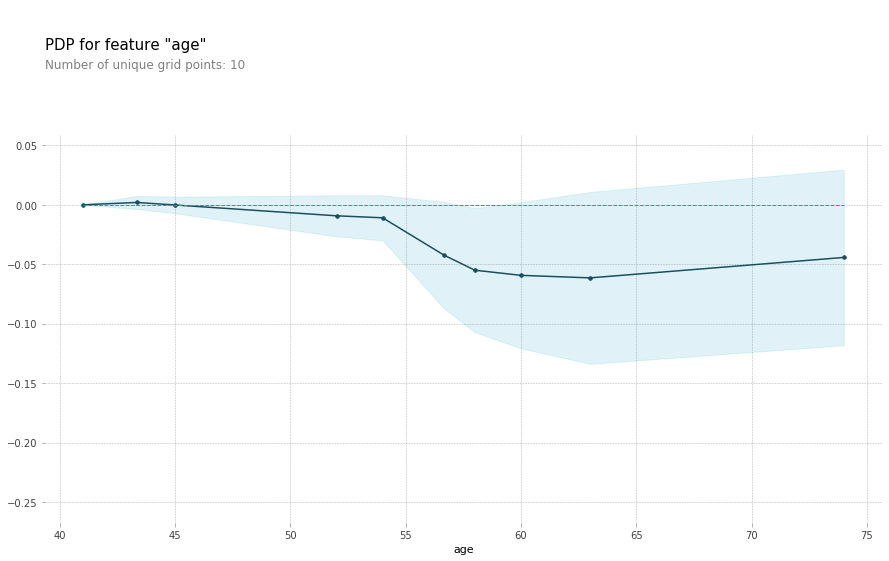

In [46]:
pdp_plot(isolated, feature_name=feature);

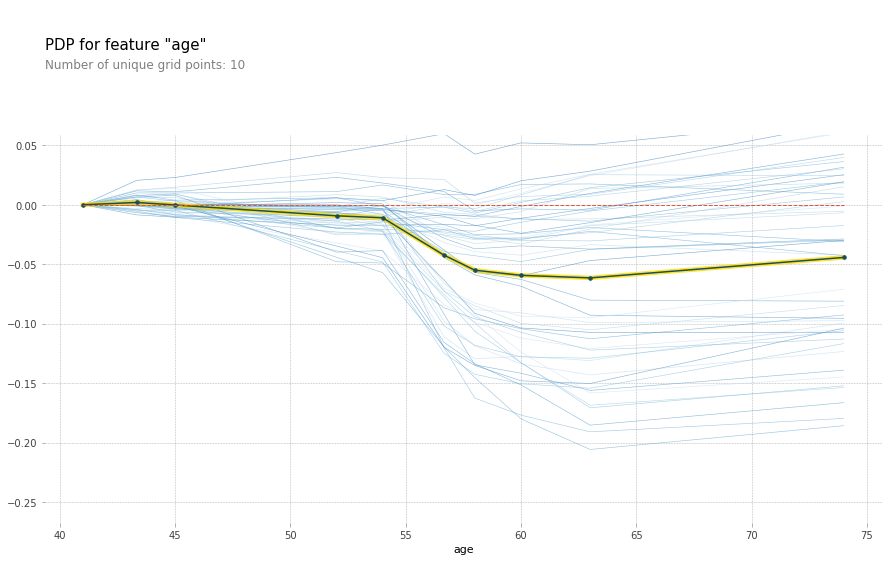

In [47]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=1);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


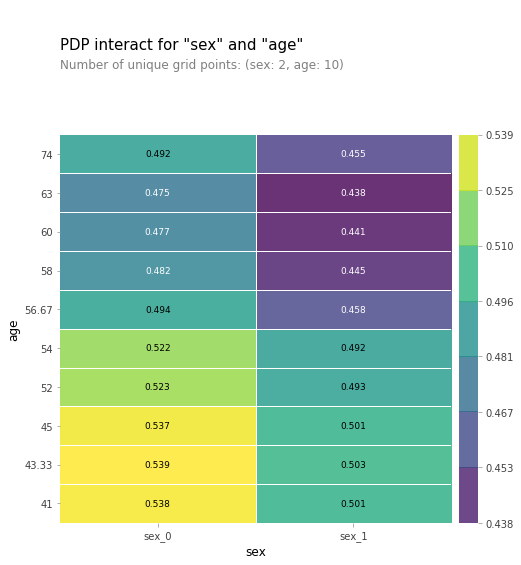

In [48]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features=['sex','age']

interaction = pdp_interact(
    model=rf,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

###For safe keep

In [0]:
# ----------------------------------------------------------------------------------

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8163265306122449


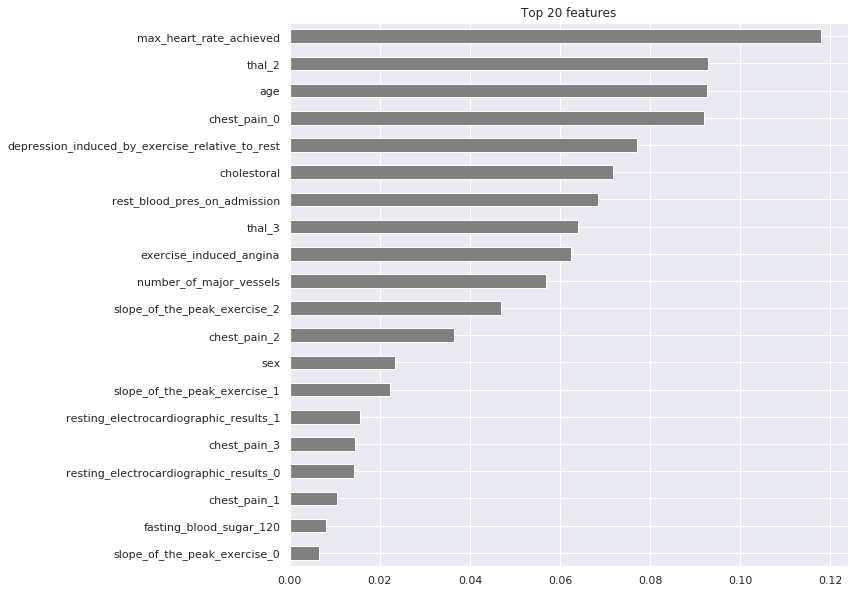

In [0]:
# Get feature importances for RandomForestClassifier
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
# -----------------------------------------------------------

###Drop-Column importancies

In [0]:
# DROP-COLUMN IMPORTANCIES

In [78]:
column  = 'fasting_blood_sugar_120'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=400, max_features='auto', max_depth=70,
                           min_samples_leaf=2, min_samples_split=5,
                           random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=250, max_depth=7, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without fasting_blood_sugar_120: 0.8571428571428571
Validation Accuracy with fasting_blood_sugar_120: 0.8367346938775511
Drop-Column Importance for fasting_blood_sugar_120: -0.020408163265306034


In [79]:
# Fit with all the columns
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=400, max_features='auto', max_depth=70,
                           min_samples_leaf=2, min_samples_split=5,
                           random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

for column in X_train.columns:

  # Fit without column
  pipeline = make_pipeline(
      ce.OrdinalEncoder(), 
      SimpleImputer(strategy='median'), 
      RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
  )
  pipeline.fit(X_train.drop(columns=column), y_train)
  score_without = pipeline.score(X_val.drop(columns=column), y_val)

  # Compare the error with & without column
  print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy with fasting_blood_sugar_120: 0.8571428571428571
Drop-Column Importance for age: 0.0
Drop-Column Importance for sex: 0.0
Drop-Column Importance for rest_blood_pres_on_admission: 0.04081632653061218
Drop-Column Importance for cholestoral: 0.04081632653061218
Drop-Column Importance for fasting_blood_sugar_120: 0.0
Drop-Column Importance for max_heart_rate_achieved: 0.020408163265306034
Drop-Column Importance for exercise_induced_angina: 0.04081632653061218
Drop-Column Importance for depression_induced_by_exercise_relative_to_rest: 0.020408163265306034
Drop-Column Importance for number_of_major_vessels: 0.04081632653061218
Drop-Column Importance for chest_pain_0: 0.020408163265306034
Drop-Column Importance for chest_pain_1: 0.04081632653061218
Drop-Column Importance for chest_pain_2: 0.04081632653061218
Drop-Column Importance for chest_pain_3: 0.04081632653061218
Drop-Column Importance for resting_electrocardiographic_results_0: 0.020408163265306034
Drop-Column Importa

###Permutation

In [80]:
# Fit with all the data
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=400, max_features='auto', max_depth=70,
                           min_samples_leaf=2, min_samples_split=5,
                           random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with: {score_with}')

Validation Accuracy with: 0.8571428571428571


In [81]:
# Before: Sequence of features to be permuted
feature = 'thal_2'
X_val[feature].head()

180    0
55     1
155    1
290    0
49     1
Name: thal_2, dtype: uint8

In [82]:
# Before: Distribution of quantity
X_val[feature].value_counts().head()

0    26
1    23
Name: thal_2, dtype: int64

In [0]:
# Permute the dataset
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

In [85]:
# After: Sequence of features to be permuted
X_val_permuted[feature].head()

180    0
55     0
155    0
290    1
49     0
Name: thal_2, dtype: uint8

In [86]:
# Distribution hasn't changed!
X_val_permuted[feature].value_counts().head()

0    26
1    23
Name: thal_2, dtype: int64

In [0]:
column = 'thal_2'

In [88]:
# Get the permutation importance
score_permuted = rf.score(X_val_permuted, y_val)

print(f'Validation Accuracy with {column} not permuted: {score_with}')
print(f'Validation Accuracy with {column} permuted: {score_permuted}')
print(f'Permutation Importance for {column}: {score_with - score_permuted}')

Validation Accuracy with thal_2 not permuted: 0.8571428571428571
Validation Accuracy with thal_2 permuted: 0.7959183673469388
Permutation Importance for thal_2: 0.061224489795918324


###Prepare for Shap value plot

In [49]:
row = X_test.iloc[[0]]
row

age  sex  rest_blood_pres_on_admission  ...  thal_1  thal_2  thal_3
179   57    1                           150  ...       1       0       0

[1 rows x 22 columns]

In [50]:
rf.predict(row)

array([0])

In [0]:
!pip install shap

In [0]:
import shap

###XGBClassifier & Shapley value

In [401]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.910768	validation_1-auc:0.861111
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.92408	validation_1-auc:0.912458
[2]	validation_0-auc:0.931602	validation_1-auc:0.914983
[3]	validation_0-auc:0.939881	validation_1-auc:0.905724
[4]	validation_0-auc:0.937392	validation_1-auc:0.907407
[5]	validation_0-auc:0.943236	validation_1-auc:0.902357
[6]	validation_0-auc:0.951299	validation_1-auc:0.905724
[7]	validation_0-auc:0.957684	validation_1-auc:0.904882
[8]	validation_0-auc:0.961526	validation_1-auc:0.906566
[9]	validation_0-auc:0.9625	validation_1-auc:0.904882
[10]	validation_0-auc:0.963799	validation_1-auc:0.896465
[11]	validation_0-auc:0.964935	validation_1-auc:0.907407
[12]	validation_0-auc:0.966991	validation_1-auc:0.910774
Stopping. Best iteration:
[2]	validation_0-auc:0.931602	validation_1-auc:0.914983



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [402]:
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.8382034632034632


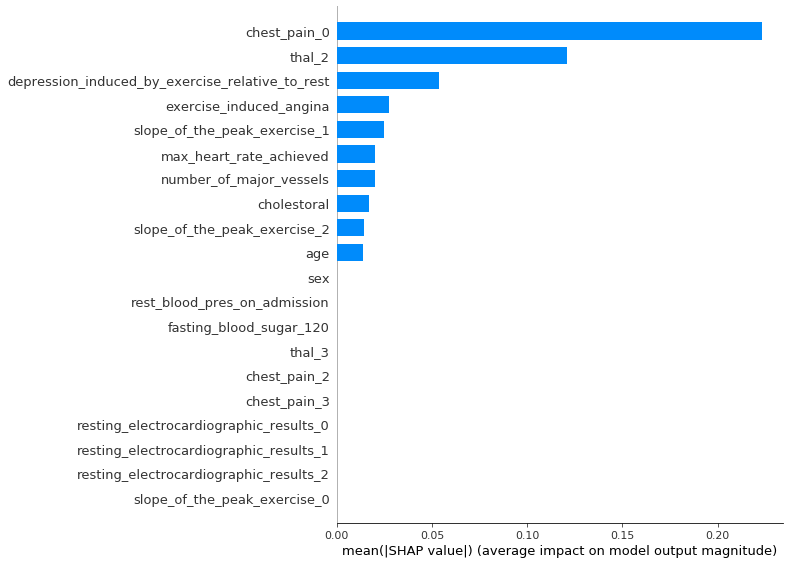

In [403]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [404]:
row = X_test.iloc[[20]]
explainer=shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit'              # For classification, this returns predicted probs
)

In [405]:
def explain(row_number):
    positive_class = 'status_group'
    positive_class_index = 1

    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # Show predictiion & probability
    print(f'The model predicts this patient have a diseas? {pred}, with {pred_proba:.0f}% probability.')
    
    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)

    # Get top 3 "pros & cons" for got_disease
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # Show top 3 reason for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')

    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0]
    print(f'- {feature_name} is {feature_value}.')

    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit' # For classification, this shows predicted probabilities
    )

explain(5)

The model predicts this patient have a diseas? 0, with 56% probability.


Top 3 reasons for prediction:
1. thal_2 is 0.0.
2. slope_of_the_peak_exercise_1 is 1.0.
3. max_heart_rate_achieved is 112.0.


Top counter-argument against prediction:
- chest_pain_0 is 0.0.


In [406]:
explain(10)

The model predicts this patient have a diseas? 0, with 51% probability.


Top 3 reasons for prediction:
1. chest_pain_0 is 1.0.
2. thal_2 is 0.0.
3. exercise_induced_angina is 1.0.


Top counter-argument against prediction:
- depression_induced_by_exercise_relative_to_rest is 0.0.


###Random Forest Classifier: got_disease + shap values

In [407]:
class_index = 1
y_pred_proba = rf.predict_proba(X_test)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.895021645021645


In [408]:
hd.head(1)

index  age  sex  ...  thal_1  thal_2  thal_3
0      0   63    1  ...       1       0       0

[1 rows x 25 columns]

In [0]:
# I can add any of the columns as the feature explanation for my prediction

df = pd.DataFrame({
    'index': test_id, 
    'pred_proba': y_pred_proba, 
    'status_group': y_test
})

df = df.merge(
     hd[['index', 'age', 'max_heart_rate_achieved', 'chest_pain_0', 'thal_2', 'thal_3', 'chest_pain_2', 'target',
         'cholestoral', 'exercise_induced_angina', 'number_of_major_vessels', 'rest_blood_pres_on_admission',
         'fasting_blood_sugar_120', 'depression_induced_by_exercise_relative_to_rest', 'chest_pain_1',
         'thal_1']], 
     how='left'
)

In [410]:
df.head(2)

index  pred_proba  ...  chest_pain_1  thal_1
0    179    0.132188  ...             0       1
1    197    0.350151  ...             0       0

[2 rows x 18 columns]

In [411]:
df.shape

(61, 18)

In [0]:
# My baseline was 55%, 
# for the possible patients with a heart disease I used 70%

In [0]:
healthy = df['status_group'] == 0
got_disease = ~healthy
right = (got_disease) == (df['pred_proba'] > 0.70)
wrong = ~right

In [413]:
df[got_disease & right].head()

index  pred_proba  ...  chest_pain_1  thal_1
6     160    0.875167  ...             1       0
8     136    0.842683  ...             0       0
13    102    0.801420  ...             1       0
14    130    0.885399  ...             0       0
15    100    0.800774  ...             0       0

[5 rows x 18 columns]

In [414]:
df[got_disease & right].shape

(21, 18)

In [415]:
df[got_disease & wrong].shape

(12, 18)

In [416]:
# Got disease, model's prediction was right
df[got_disease & right].sample(n=3, random_state=1).sort_values(by='pred_proba', ascending=False)

index  pred_proba  ...  chest_pain_1  thal_1
14    130    0.885399  ...             0       0
31     41    0.875773  ...             1       0
46     65    0.864400  ...             0       0

[3 rows x 18 columns]

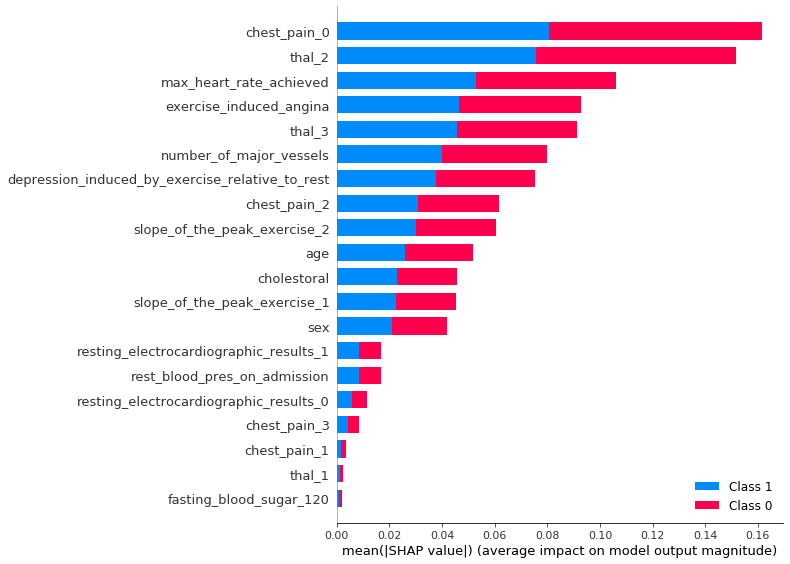

In [381]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [417]:
df[got_disease & right].sample(n=5, random_state=1).sort_values(by='pred_proba', ascending=False)

index  pred_proba  ...  chest_pain_1  thal_1
55    123    0.910883  ...             0       0
54    131    0.899445  ...             1       0
14    130    0.885399  ...             0       0
31     41    0.875773  ...             1       0
46     65    0.864400  ...             0       0

[5 rows x 18 columns]

In [433]:
row = X_test.iloc[[55]]
explainer=shap.TreeExplainer(rf)
# row_processed = rf.transform(row)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[1],
    features=row,
    link='logit'              # For classification, this returns predicted probs
)

In [436]:
df[got_disease & wrong].sample(n=5, random_state=1).sort_values(by='pred_proba', ascending=True)

index  pred_proba  ...  chest_pain_1  thal_1
52     83    0.469267  ...             0       0
29    151    0.550625  ...             0       0
19      0    0.577384  ...             0       1
11    107    0.661098  ...             0       0
27    141    0.690012  ...             0       0

[5 rows x 18 columns]

In [0]:
# As you can see only 2 patients got the hear disease with the score 55% and lower.

In [443]:
row = X_test.iloc[[52]]
explainer=shap.TreeExplainer(rf)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[1],
    features=row,
    link='logit'              # For classification, this returns predicted probs
)

In [445]:
df[healthy & wrong]

index  pred_proba  ...  chest_pain_1  thal_1
20    267    0.774552  ...             0       0
23    302    0.759585  ...             1       0
49    286    0.741132  ...             0       0

[3 rows x 18 columns]